# Analysis of Yelp Business Intelligence Data

We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from [Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset) although we have taken steps to pull this data into a publis s3 bucket: `s3://sta9760-yelpdataset/yelp-light/*business.json`

# Installation and Initial Setup

Begin by installing the necessary libraries that you may need to conduct your analysis. At the very least, you must install `pandas` and `matplotlib`

In [1]:
sc.install_pypi_package("pandas==1.0.3")

sc.install_pypi_package("matplotlib==3.2.1")

sc.install_pypi_package("seaborn==0.10.0")

sc.list_packages()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
7,application_1587863080217_0008,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached pandas-1.0.3-cp36-cp36m-manylinux1_x86_64.whl (10.0 MB)
  Using cached python_dateutil-2.8.1-py2.py3-none-any.whl (227 kB)

  Using cached matplotlib-3.2.1-cp36-cp36m-manylinux1_x86_64.whl (12.4 MB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached kiwisolver-1.2.0-cp36-cp36m-manylinux1_x86_64.whl (88 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)

  Using cached seaborn-0.10.0-py3-none-any.whl (215 kB)
  Using cached scipy-1.4.1-cp36-cp36m-manylinux1_x86_64.whl (26.1 MB)

Package                    Version
-------------------------- -------
beautifulsoup4             4.8.1
boto                       2.49.0
cycler                     0.10.0
jmespath                   0.9.4
kiwisolver                 1.2.0
lxml                       4.4.2
matplotlib                 3.2.1
mysqlclient                1.4.6
nltk                       3.4.5
nose                       1.3.4
numpy                      1.14.5
pandas                     1.0

## Importing

Now, import the installed packages from the previous block below.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading Data

We are finally ready to load data. Using `spark` load the data from S3 into a `dataframe` object that we can manipulate further down in our analysis.

In [3]:
business = spark.read.json('s3://9760-spark-data/yelp_academic_dataset_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Overview of Data

Display the number of rows and columns in our dataset.

In [4]:
f'Total Rows: {business.count():,}'

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'Total Rows: 209,393'

In [5]:
f'Total Columns: {len(business.dtypes)}'

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'Total Columns: 14'

Display the DataFrame schema below.

In [6]:
business.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the first 5 rows with the following columns:

* `business_id`
* `name`
* `city`
* `state`
* `categories`

In [7]:
business.select('business_id', 'name', 'city', 'state', 'categories').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+--------------------+
|         business_id|                name|           city|state|          categories|
+--------------------+--------------------+---------------+-----+--------------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|Health & Medical,...|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|Home Services, Pl...|
+--------------------+--------------------+---------------+-----+--------------------+
only showing top 5 rows

# Analyzing Categories

Let's now answer this question: **how many unique categories are represented in this dataset?**

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

* How many businesses are categorized as `Active Life`, for instance
* What are the top 20 most popular categories available?

## Association Table

We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

For instance, given the following:


| business_id | categories |
|-------------|------------|
| abcd123     | a,b,c      |

We would like to derive something like:

| business_id | category |
|-------------|------------|
| abcd123     | a          |
| abcd123     | b          |
| abcd123     | c          |


What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

Implement the code necessary to derive the table described from your original yelp dataframe.

In [8]:
from pyspark.sql.functions import split, explode, desc

categories = business.select('business_id', explode(split(business.categories, ', ')).alias('category'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Display the first 5 rows of your association table below.

In [9]:
categories.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------------+
|         business_id|        category|
+--------------------+----------------+
|f9NumwFMBDn751xgF...|     Active Life|
|f9NumwFMBDn751xgF...|Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|     Guns & Ammo|
|f9NumwFMBDn751xgF...|        Shopping|
|Yzvjg0SayhoZgCljU...|Health & Medical|
+--------------------+----------------+
only showing top 5 rows

## Total Unique Categories

Finally, we are ready to answer the question: **what is the total number of unique categories available?**

Below, implement the code necessary to calculate this figure.

In [10]:
categories.select('category').distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1336

## Top Categories By Business

Now let's find the top categories in this dataset by rolling up categories.

### Counts of Businesses / Category

So now, let's unroll our distinct count a bit and display the per count value of businesses per category.

The expected output should be:

| category | count |
|-------------|------------|
| a     | 15         |
| b     | 2          |
| c     | 45          |

Or something to that effect.

In [11]:
category_counts = categories.groupBy('category').count()
category_counts.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----+
|           category|count|
+-------------------+-----+
|     Paddleboarding|   36|
|     Dermatologists|  341|
|   Historical Tours|   54|
|   Hot Air Balloons|   21|
|Mobile Home Dealers|   16|
|       Aerial Tours|   28|
|      Skating Rinks|  104|
|  Signature Cuisine|    1|
|             Fondue|   54|
|      Data Recovery|  195|
|  Pet Waste Removal|   34|
|      Videographers|  169|
|    Pet Photography|   49|
|        Boat Repair|  100|
|            Beaches|   74|
|       Contract Law|   13|
|        Hobby Shops|  828|
|           Day Spas| 2880|
|              Reiki|  312|
|Private Jet Charter|   10|
+-------------------+-----+
only showing top 20 rows

### Bar Chart of Top Categories

With this data available, let us now build a barchart of the top 20 categories. 

**HINT**: don't forget about the matplotlib magic!

```
%matplot plt
```

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

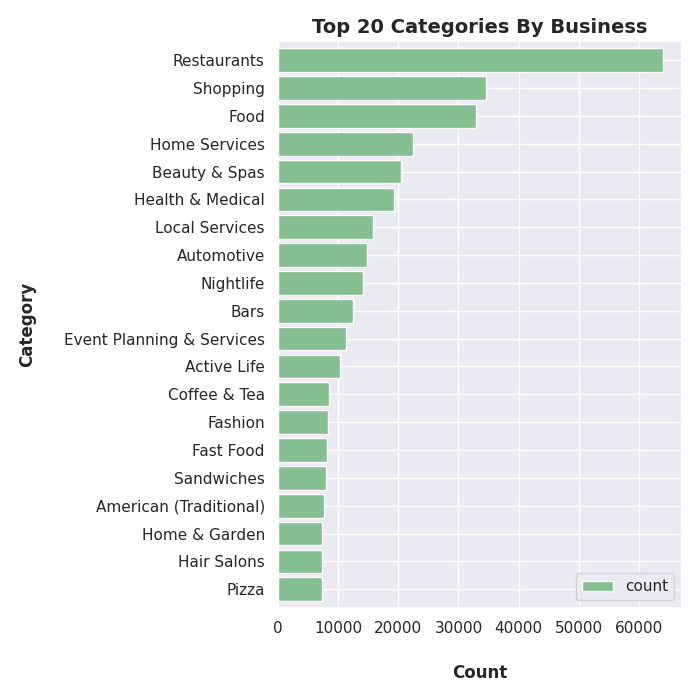

In [12]:
sns.set()

top_20 = category_counts.sort(desc('count')).limit(20).toPandas()

ax = top_20.plot(kind='barh', x='category', y='count', 
            figsize=(7, 7), color='#86bf91', zorder=2, width=0.85)

ax.invert_yaxis()

ax.set_xlabel("Count", labelpad=20, weight='bold', size=12)

ax.set_ylabel("Category", labelpad=20, weight='bold', size=12)

ax.set_title("Top 20 Categories By Business", weight='bold', size=14)

plt.tight_layout()

%matplot plt

# Do Yelp Reviews Skew Negative?

Oftentimes, it is said that the only people who write a written review are those who are extremely _dissatisfied_ or extremely _satisfied_ with the service received. 

How true is this really? Let's try and answer this question.

## Loading Review Data

Begin by loading the review data set from S3 and printing schema to determine what data is available.

In [13]:
review = spark.read.json('s3://9760-spark-data/yelp_academic_dataset_review.json')
review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Let's begin by listing the `business_id` and `stars` columns together for the user reviews data.

In [14]:
business_stars = review.select('business_id', 'stars')
business_stars.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|-MhfebM0QIsKt87iD...|  2.0|
|lbrU8StCq3yDfr-QM...|  1.0|
|HQl28KMwrEKHqhFrr...|  5.0|
|5JxlZaqCnk1MnbgRi...|  1.0|
|IS4cv902ykd8wj1TR...|  4.0|
+--------------------+-----+
only showing top 5 rows

Now, let's aggregate along the `stars` column to get a resultant dataframe that displays _average stars_ per business as accumulated by users who **took the time to submit a written review**.

In [15]:
avg_stars = business_stars.groupBy('business_id').mean()
avg_stars.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|        avg(stars)|
+--------------------+------------------+
|ATeOjZzE3VOI-RW7F...| 3.433734939759036|
|RMjCnixEY5i12Ciqn...|3.5316455696202533|
|vbUABNAQI2iwN7v0x...|2.4545454545454546|
|VHsNB3pdGVcRgs6C3...| 3.411764705882353|
|r-W1HPIZ3V6S2DaXh...| 4.852459016393443|
+--------------------+------------------+
only showing top 5 rows

Now the fun part - let's join our two dataframes (reviews and business data) by `business_id`. 

In [16]:
business_temp = business.select('business_id', 'name', 'city', 'state', 'stars')
business_review = business_temp.join(avg_stars, on=['business_id'], how='inner')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's see a few of these:

In [17]:
business_review.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-----------+-----+-----+------------------+
|         business_id|                name|       city|state|stars|        avg(stars)|
+--------------------+--------------------+-----------+-----+-----+------------------+
|--9e1ONYQuAa-CB_R...|Delmonico Steakhouse|  Las Vegas|   NV|  4.0|  4.11784140969163|
|-6c_bJblLXUwoWfmY...|Neo-Paws Internat...|    Toronto|   ON|  2.5|2.3333333333333335|
|-ElDqujEn1u64ynQr...| McFarling Law Group|  Las Vegas|   NV|  4.5|             4.375|
|-Gh9a15ijNii-8rnp...|Volvo of Mississauga|Mississauga|   ON|  3.5|3.3333333333333335|
|-I06hkMFrX0KBqu61...|Andre Agassi Coll...|  Las Vegas|   NV|  5.0|               5.0|
+--------------------+--------------------+-----------+-----+-----+------------------+
only showing top 5 rows

Compute a new dataframe that calculates what we will call the _skew_ (for lack of a better word) between the avg stars accumulated from written reviews and the _actual_ star rating of a business (ie: the average of stars given by reviewers who wrote an actual review **and** reviewers who just provided a star rating).

The formula you can use is something like:

```
(row['avg(stars)'] - row['stars']) / row['stars']
```

If the **skew** is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If **skew** is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [18]:
from pyspark.sql.types import IntegerType, StringType, DoubleType
from pyspark.sql.functions import udf, col

skew = lambda avg, actual: (avg - actual) / actual
skew_udf = udf(skew, DoubleType())

business_review_skew = business_review.withColumn('skew', skew_udf(col('avg(stars)'), col('stars')))
business_review_skew.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-----------+-----+-----+------------------+--------------------+
|         business_id|                name|       city|state|stars|        avg(stars)|                skew|
+--------------------+--------------------+-----------+-----+-----+------------------+--------------------+
|--9e1ONYQuAa-CB_R...|Delmonico Steakhouse|  Las Vegas|   NV|  4.0|  4.11784140969163|0.029460352422907565|
|-6c_bJblLXUwoWfmY...|Neo-Paws Internat...|    Toronto|   ON|  2.5|2.3333333333333335|-0.06666666666666661|
|-ElDqujEn1u64ynQr...| McFarling Law Group|  Las Vegas|   NV|  4.5|             4.375|-0.02777777777777...|
|-Gh9a15ijNii-8rnp...|Volvo of Mississauga|Mississauga|   ON|  3.5|3.3333333333333335|-0.04761904761904...|
|-I06hkMFrX0KBqu61...|Andre Agassi Coll...|  Las Vegas|   NV|  5.0|               5.0|                 0.0|
+--------------------+--------------------+-----------+-----+-----+------------------+--------------------+
only showing top 5 rows

And finally, graph it!

In [19]:
skew = business_review_skew.select('skew').toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

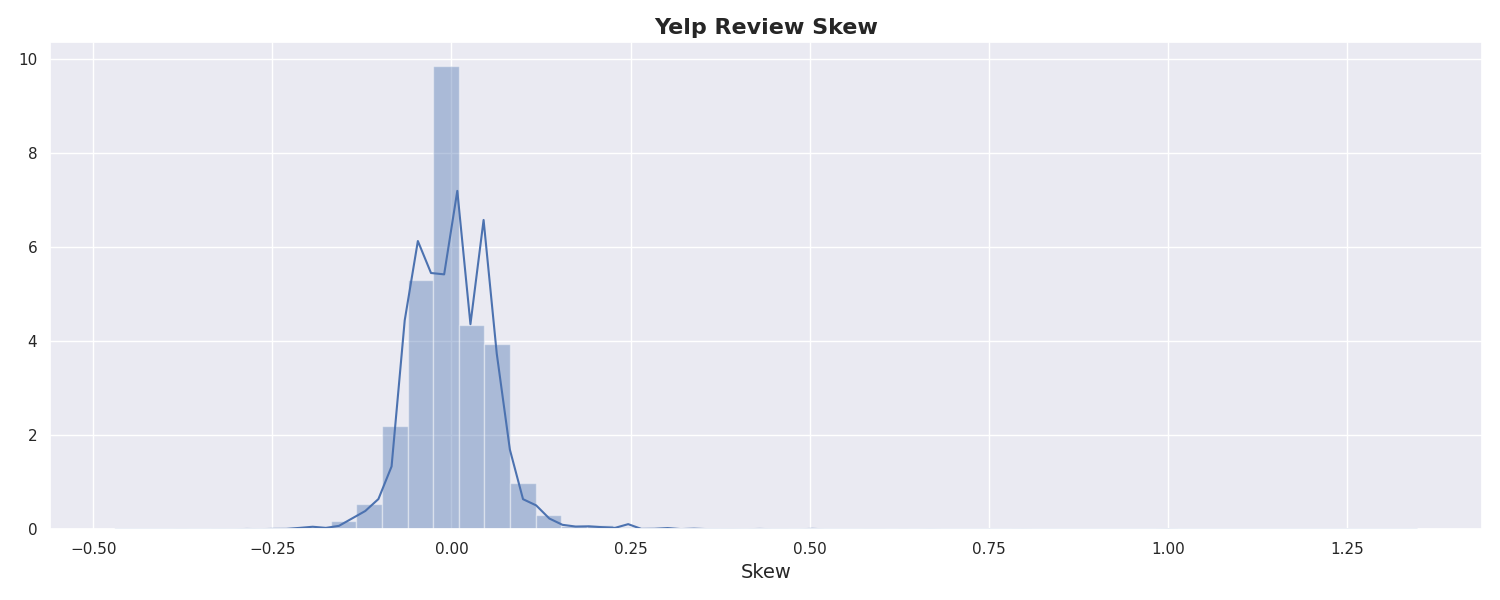

In [20]:
plt.figure(figsize=(15,6))

ax = sns.distplot(skew['skew'])

ax.set_xlabel('Skew', size=14)

plt.title("Yelp Review Skew", weight='bold', size=16)

plt.tight_layout()

%matplot plt

So, do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph. 

---

The distribution of skew appears to be normal, but skewed to the right. The extreme values of positively skewed businesses causes this. The implications of the graph are that  the *satisfaction* level of reviewers who left positively skewed reviews is greater than the *dissatisfaction* level of reviewers who left negatively skewed reviews.

Although it may appear that the average skew is negative, we can see in the cell below that the average skew is actually slightly positive, and the median skew is 0.

In [21]:
skew.describe()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                skew
count  209393.000000
mean        0.001235
std         0.055235
min        -0.454545
25%        -0.033898
50%         0.000000
75%         0.035714
max         1.333333

To answer the question if Yelp reviews skew negative, we can formulate a hypothesis test the population mean skew.

### One-Tailed Single Sample t-test

$$
H_o: \mu_{skew} \geq 0 \\
H_a: \mu_{skew} < 0 
$$

- Sample Size:

$$
n = 209393
$$

- Sample Mean: 

$$
\bar x = 0.001235 
$$

- Sample Standard Deviation:

$$
s = 0.055235
$$

- Test Statistic:

$$
t = \frac{\bar x - \mu_{skew}}{\frac{s}{\sqrt n}} = \frac{0.001235 - 0}{\frac{0.055235}{\sqrt{209393}}} = 10.234
$$

In [22]:
from scipy import stats

t, p = stats.ttest_1samp(skew['skew'], 0)
p /= 2

print('Test Statistic: {}\np-value: {}'.format(t,p))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Statistic: 10.234180992254487
p-value: 7.062066589952781e-25

Although the `p-value` is less than 0.05, the `test statistic` is positive, which means that the result of the t-test is inconclusive. We cannot reject the null hypothesis $H_o: \mu_{skew} \geq 0$. In the context of the question of whether Yelp reviews skew negative, our analysis does not prove anything.

# Should the Elite be Trusted? 

For the final portion - you have a choice:

* Try and analyze some interesting dimension to this data. The **ONLY** requirement is that you must use the **Users** dataset and join on either the **business* or **reviews** dataset
* Or, you may try and answer the question posed: how accurate or close are the ratings of an "elite" user (check Users table schema) vs the actual business rating.

Feel free to use any and all methodologies at your disposal - only requirement is you must render one visualization in your analysis

---

In this final section, the question of **"Should the Elite be Trusted?"** will be explored. The goal is to analyze and visualize the accuracy of star ratings for both elite and non-elite users and see how they change over time.

### User Data

In [23]:
user = spark.read.json('s3://9760-spark-data/yelp_academic_dataset_user.json')
user.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

In [24]:
user.select('user_id', 'elite').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|             user_id|               elite|
+--------------------+--------------------+
|ntlvfPzc8eglqvk92...|                    |
|FOBRPlBHa3WPHFB5q...|2008,2009,2010,20...|
|zZUnPeh2hEp0WydbA...|                2010|
|QaELAmRcDc5TfJEyl...|                2009|
|xvu8G900tezTzbbfq...|2009,2010,2011,20...|
+--------------------+--------------------+
only showing top 5 rows

### "Break Out" The `elite` Column

In [25]:
user_temp = user.select('user_id', explode(split(user.elite, ',')).alias('elite_year'))

user_temp = user_temp.withColumn('elite_year', user_temp.elite_year.cast(IntegerType()))

user_temp.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------+
|             user_id|elite_year|
+--------------------+----------+
|ntlvfPzc8eglqvk92...|      null|
|FOBRPlBHa3WPHFB5q...|      2008|
|FOBRPlBHa3WPHFB5q...|      2009|
|FOBRPlBHa3WPHFB5q...|      2010|
|FOBRPlBHa3WPHFB5q...|      2011|
+--------------------+----------+
only showing top 5 rows

### Joining Review & Business Data

In [26]:
from pyspark.sql.functions import to_date, year

business_temp = business.select('business_id', 'stars').withColumnRenamed('stars', 'business_stars')

review_temp = review.select('review_id', 'business_id', 'user_id', 'stars', 
                            year(to_date(review.date, 'yyyy-MM-dd HH:mm:ss')).alias('year'))

review_business_stars = review_temp.join(business_temp, on=['business_id'], how='left')
review_business_stars.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+-----+----+--------------+
|         business_id|           review_id|             user_id|stars|year|business_stars|
+--------------------+--------------------+--------------------+-----+----+--------------+
|-MhfebM0QIsKt87iD...|xQY8N_XvtGbearJ5X...|OwjRMXRC0KyPrIlcj...|  2.0|2015|           3.5|
|lbrU8StCq3yDfr-QM...|UmFMZ8PyXZTY2Qcwz...|nIJD_7ZXHq-FX8byP...|  1.0|2013|           1.5|
|HQl28KMwrEKHqhFrr...|LG2ZaYiOgpr2DK_90...|V34qejxNsCbcgD8C0...|  5.0|2015|           4.0|
|5JxlZaqCnk1MnbgRi...|i6g_oA9Yf9Y31qt0w...|ofKDkJKXSKZXu5xJN...|  1.0|2011|           3.5|
|IS4cv902ykd8wj1TR...|6TdNDKywdbjoTkize...|UgMW8bLE0QMJDCkQ1...|  4.0|2017|           3.5|
+--------------------+--------------------+--------------------+-----+----+--------------+
only showing top 5 rows

### Joining Review & Business & User Data

In [27]:
rev_bus_usr = review_business_stars.join(user_temp, on=['user_id'], how='outer')
rev_bus_usr.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+-----+----+--------------+----------+
|             user_id|         business_id|           review_id|stars|year|business_stars|elite_year|
+--------------------+--------------------+--------------------+-----+----+--------------+----------+
|-0Ji0nOyFe-4yo8BK...|pmrHuQiy25xKB86tb...|a0r23pA6D4HDLb9P5...|  4.0|2014|           4.0|      null|
|-0XPr1ilUAfp-yIXZ...|QhwaGi1niDeVEHMRt...|DfAjJ3KCimOdqplv4...|  2.0|2012|           2.5|      null|
|-1KKYzibGPyUX-Mwk...|L772e6l2Yd0DJEyCB...|TbU3S2kWmfajlVov3...|  4.0|2014|           3.0|      2011|
|-1KKYzibGPyUX-Mwk...|L772e6l2Yd0DJEyCB...|TbU3S2kWmfajlVov3...|  4.0|2014|           3.0|      2012|
|-1KKYzibGPyUX-Mwk...|L772e6l2Yd0DJEyCB...|TbU3S2kWmfajlVov3...|  4.0|2014|           3.0|      2013|
+--------------------+--------------------+--------------------+-----+----+--------------+----------+
only showing top 5 rows

### Extract Non-Elite User Data

In [28]:
non_elite_reviews = rev_bus_usr.filter(rev_bus_usr.elite_year.isNull())
non_elite_reviews.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+-----+----+--------------+----------+
|             user_id|         business_id|           review_id|stars|year|business_stars|elite_year|
+--------------------+--------------------+--------------------+-----+----+--------------+----------+
|-0Ji0nOyFe-4yo8BK...|pmrHuQiy25xKB86tb...|a0r23pA6D4HDLb9P5...|  4.0|2014|           4.0|      null|
|-0XPr1ilUAfp-yIXZ...|QhwaGi1niDeVEHMRt...|DfAjJ3KCimOdqplv4...|  2.0|2012|           2.5|      null|
|-1zQA2f_syMAdA04P...|aNe8ofTYrealxqv7V...|08j8zUlyJylKcJa_r...|  5.0|2016|           3.5|      null|
|-1zQA2f_syMAdA04P...|5c-b0ALS_DyLvRCGr...|_aY8ReBavQVGHhCh7...|  1.0|2017|           2.5|      null|
|-1zQA2f_syMAdA04P...|fuC3sui68QWg-rqld...|QCQJC9kbCkhzTRosS...|  1.0|2018|           3.0|      null|
+--------------------+--------------------+--------------------+-----+----+--------------+----------+
only showing top 5 rows

### Extract Elite User Data

In [29]:
elite_reviews = rev_bus_usr.filter(rev_bus_usr.year==rev_bus_usr.elite_year)
elite_reviews.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+-----+----+--------------+----------+
|             user_id|         business_id|           review_id|stars|year|business_stars|elite_year|
+--------------------+--------------------+--------------------+-----+----+--------------+----------+
|FZQXGfmkMASFWq3Jn...|KVsv8wRGnLX8QWoNZ...|oS5Baq2qIOh-3fNRx...|  3.0|2006|           4.0|      2006|
|FZQXGfmkMASFWq3Jn...|ujHiaprwCQ5ewziu0...|XJ4N_sV7p59_Y79iQ...|  5.0|2006|           3.5|      2006|
|FZQXGfmkMASFWq3Jn...|tRUBzjp-25SdY-qFW...|tvhdNSGqn5IAatYiI...|  4.0|2006|           3.0|      2006|
|FZQXGfmkMASFWq3Jn...|DxgSVufr_6y_Rc63C...|6oALQf6cOf7bxSkB6...|  4.0|2006|           4.5|      2006|
|jwMDC4ZCoiDXl9qZt...|57Ot-sRTzL925ipv-...|tcDf24FmUImidKeG1...|  5.0|2006|           3.5|      2006|
+--------------------+--------------------+--------------------+-----+----+--------------+----------+
only showing top 5 rows

### Aggregate Yearly Average Difference in `stars` 

- #### Yearly Non-Elite Data

In [30]:
from pyspark.sql.functions import mean

non_elite_diff = non_elite_reviews.withColumn('non_elite_stars_diff', 
                                              non_elite_reviews.stars - non_elite_reviews.business_stars)

non_elite_year_diff = non_elite_diff.groupBy('year').agg(mean('non_elite_stars_diff'))

non_elite_year_diff = non_elite_year_diff.sort('year')

non_elite_year_diff.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+-------------------------+
|year|avg(non_elite_stars_diff)|
+----+-------------------------+
|2004|                     0.75|
|2005|       0.5068493150684932|
|2006|       0.2710880195599022|
|2007|       0.2153315081537912|
|2008|       0.1168708597478453|
|2009|      0.06386955877998224|
|2010|      0.05933814048994795|
|2011|     0.024171091827483487|
|2012|     -0.02147622582011381|
|2013|      -0.0282225618404219|
|2014|     -0.00922987091908...|
|2015|     -0.01239640934334...|
|2016|     -0.02052381933019378|
|2017|     -0.03884251956445166|
|2018|     -0.06250701306861961|
|2019|     -0.10160517923312276|
+----+-------------------------+

- #### Yearly Elite Data

In [31]:
elite_diff = elite_reviews.withColumn('elite_stars_diff', 
                                      elite_reviews.stars - elite_reviews.business_stars)

elite_year_diff = elite_diff.groupBy('year').agg(mean('elite_stars_diff'))

elite_year_diff = elite_year_diff.sort('year')

elite_year_diff.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+---------------------+
|year|avg(elite_stars_diff)|
+----+---------------------+
|2006|   0.2660586835844568|
|2007|  0.24943687018375815|
|2008|  0.13426656151419558|
|2009|  0.12784468991216397|
|2010|  0.11065668202764976|
|2011|   0.1082114856102697|
|2012|  0.11504091993151973|
|2013|  0.09694511403671426|
|2014|  0.08177112679418984|
|2015|   0.0918269411014884|
|2016|  0.10704832237478244|
|2017|  0.12723198828731686|
|2018|  0.16126663100605382|
+----+---------------------+

### Concatenate Elite & Non-Elite Yearly Data

Here an inner join is used since the yearly elite and non-elite data have different year ranges. 

- Non-Elite : 2004 - 2019
    

- Elite Data : 2006 - 2018

The resulting dataframe contains both elite and non-elite from 2006 - 2018.

In [32]:
year_diff = non_elite_year_diff.join(elite_year_diff, on=['year'], how='inner').sort('year')

year_diff.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+-------------------------+---------------------+
|year|avg(non_elite_stars_diff)|avg(elite_stars_diff)|
+----+-------------------------+---------------------+
|2006|       0.2710880195599022|   0.2660586835844568|
|2007|       0.2153315081537912|  0.24943687018375815|
|2008|       0.1168708597478453|  0.13426656151419558|
|2009|      0.06386955877998224|  0.12784468991216397|
|2010|      0.05933814048994795|  0.11065668202764976|
|2011|     0.024171091827483487|   0.1082114856102697|
|2012|     -0.02147622582011381|  0.11504091993151973|
|2013|      -0.0282225618404219|  0.09694511403671426|
|2014|     -0.00922987091908...|  0.08177112679418984|
|2015|     -0.01239640934334...|   0.0918269411014884|
|2016|     -0.02052381933019378|  0.10704832237478244|
|2017|     -0.03884251956445166|  0.12723198828731686|
|2018|     -0.06250701306861961|  0.16126663100605382|
+----+-------------------------+---------------------+

### Plot Time Series Trends For Elite & Non-Elite Users

In [33]:
year_diff_pd = year_diff.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

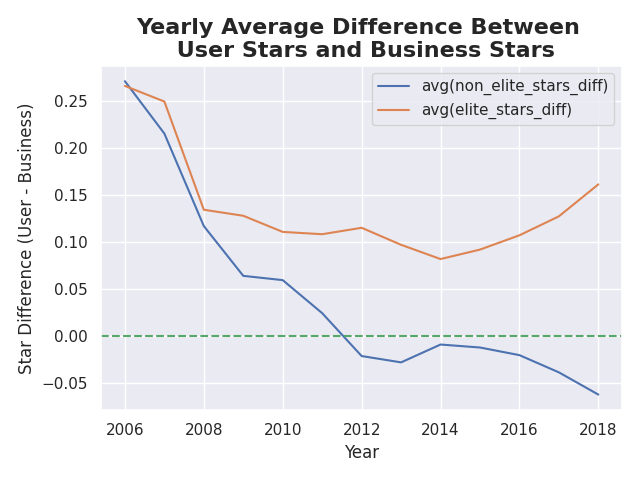

In [34]:
plt.figure()

ax = year_diff_pd.set_index('year').plot()

ax.axhline(ls='--', color='g')

ax.set_ylabel('Star Difference (User - Business)')

ax.set_xlabel('Year')

plt.title("Yearly Average Difference Between \n User Stars and Business Stars", weight='bold', size=16)

plt.tight_layout()

%matplot plt

By looking at the time series plot of the yearly average difference between user stars and business stars for both elite and non-elite users, we can certainly see that there is a difference between elite and non-elite users.

In 2006, both elite and non-elite users had similar average star difference (0.266, 0.271 respectively). 

From 2006 - 2008 the average star difference fell for both elite and non-elite users, but they still had relatively similar values.

After 2008 is when we can start seeing a difference in trends. Non-elite users generally continued to exhibit a downward trend. In 2012, the average star difference for non-elite users dropped below 0. On the other hand, Elite users display a weaker downward trend up until 2014. For the subsequent years, elite users have begun to increase their average star difference. 

Some alarming details to note about the plot is that both lines seem to be diverging over time and that the line corresponding to elite users is always above 0. It can also be seen that the average star difference for elite users is higher than that of non-elite users every single year with the exception of the year 2006.

Based on this visualization, I would infer that elite users on Yelp should **NOT** be trusted because elite users tend to "over rate" businesses. This means that on average they will give a rating that is higher than what the business rating actually is. 